Obtención de la señal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Nombre del Archivo: 17453
Dirección: nsrdb


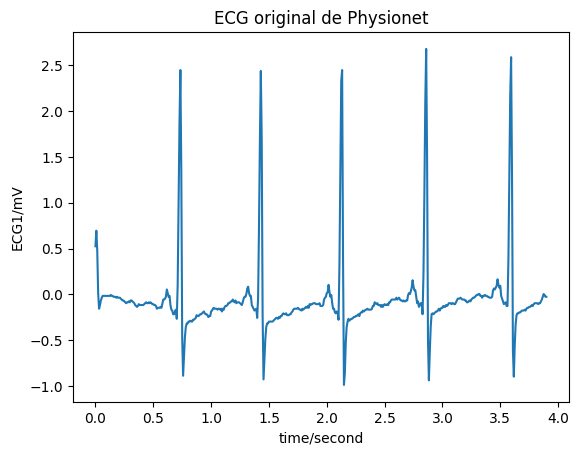

In [38]:
!pip install wfdb
!pip install biosppy
!pip install peakutils
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import wfdb
from IPython.display import Image, display
from wfdb import processing
from scipy import signal
import random
import biosppy.signals.ecg as ecg

#S_nsrdb = ['16265','16272','16273','16420','16483','16539','16773','16786','16795','17052','17453','18177','18184']
#S_afdb = ['00735', '03665','04015','04043','04048','04126','04746','04908','04936','05091','05121','05261','06426','06453','06995','07162','07859','07879','07910','08215','08219','08378','08405','08434','08455']

# Lista de todos los numeros de las señales afdb y nsrdb del Physiobank
arch = ['00735', '03665','04015','04043','04048','04126','04746','04908','04936','05091','05121','05261','06426','06453','06995','07162','07859','07879','07910','08215','08219','08378','08405','08434','08455','16265','16272','16273','16420','16483','16539','16773','16786','16795','17052','17453','18177','18184']
tarch = random.choice(arch) #Elección aleatoria del archivo

#Condicionales para identificar y sincronizar el tipo con el numero de archivo y la frecuencia de muestreo
if tarch[0] == '0':
  dir = 'afdb'
  s_freq = 250

if tarch[0] == '1':
  dir = 'nsrdb'
  s_freq = 128

#Selección aleatoria del canal (ECG1 ó ECG2)
canal= random.randint(0,1)

print("Nombre del Archivo:",tarch)
print("Dirección:",dir)

#Signal recording
record = wfdb.rdrecord(tarch, pn_dir=dir, channels=[canal],  sampto = 500) #Recordatorio de los datos sacados de physionet
annotation = wfdb.rdann(tarch, 'atr', sampto=250, pn_dir=dir)
annotation.fs = s_freq

#Ploteo
wfdb.plot_wfdb(record=record,
               title='ECG original de Physionet', 
               time_units='seconds')

#Obtención de rescate en caso de que Physionet este caído
"""
url = 'https://raw.githubusercontent.com/jesusf65/Datos-ECG/main/SIGNAL.csv'
df_ECG = pd.read_csv(url) 
df_ECG
"""

#Declaración de arreglos de señal y tiempo
ecg_signal=np.array(record.p_signal)
fs=record.fs
ecg_time=np.linspace(0,len(ecg_signal)/fs,len(ecg_signal))
ecg_signal=np.squeeze(ecg_signal) # Se elimina la dimensión que no tiene mas elementos

Filtrado para eliminación de línea de base

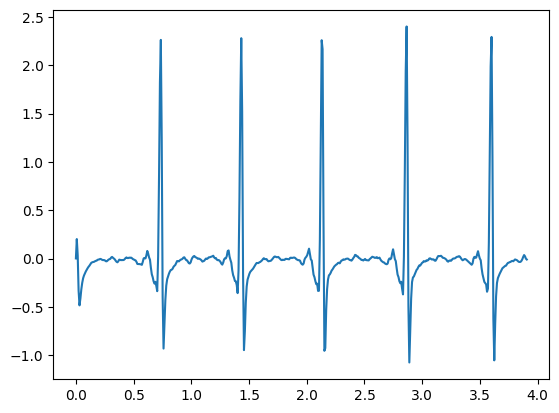

In [40]:
from scipy import signal 

#Filtro pasabanda tipo Butterworth con frecuencias de corte según el paper
b, a = signal.butter(N=1, btype='bandpass', Wn=[2.5,45], fs=s_freq) 
zi = signal.lfilter_zi(b, a) #Numerador ( b ) y denominador ( a ) polinomios del filtro IIR
ecg_NLB = signal.filtfilt(b, a, ecg_signal)
 
ps = ecg_NLB
probe = ecg_time
plt.plot(probe,ps)   #ECG Non-Linea-Base



Aisamiento del QRS

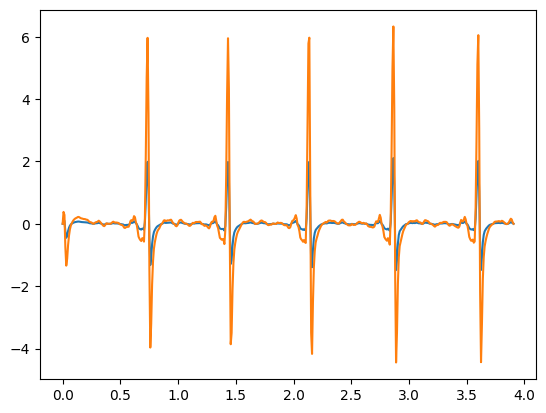

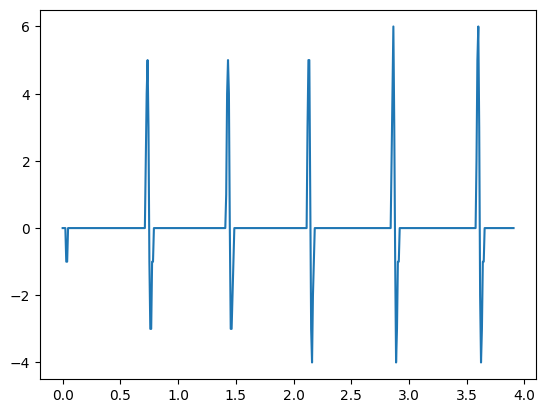

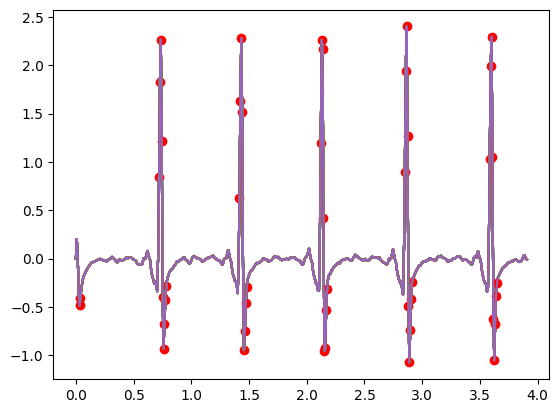

In [41]:
from wfdb.io.annotation import Annotation
import math
#El algoritmo funciona analizando la pendiente, la amplitud y la anchura de los complejos QRS presentes en la señal de ECG filtrada
##################
#De acuerdo a Pan_Tompkins se debe filtrar la señal dejando un paso de banda de frecuencias entre 5-15 Hz esto se hace ya que
#generalmente la frecuencia del segmento QRS es de 10 Hz aproximadamente

from scipy.signal import butter, lfilter
from scipy import integrate

def butter_bandpass(lowcut, highcut, fs, order=8):    
    nyq = 0.5 * fs    #se hace para cumpli con la condicion de un filtro digital que es que la frecuencia de muestreo debe ser 0 < Wn < fs/2
    high = highcut / nyq
    low = lowcut /  nyq
    c, d = butter(order, [low, high], btype='band')
    
    return c, d


def butter_bandpass_filter(data, lowcut, highcut, fs, order=8):
    c, d = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

#Filtro de aislamiento 
lowcut = 6
highcut = 16

y = butter_bandpass_filter(ecg_NLB, lowcut, highcut, fs, order=8)   
plt.plot(probe,y) #En este caso y seria el filtrado con una banda de paso de 5-11 Hz de acuerdo a Pan_Tompkins

#Amplificación de la señal para análisis
s_ampl = y*3
plt.plot(probe,s_ampl)

#truncamiento para solo dejar valores enteros
sqrs= np.trunc(s_ampl)

plt.figure()
plt.plot(probe,sqrs)


plt.figure()
#Detección y marcación de cambios de flanco en donde se presenten ondas del ECG
cont = -1 
for index in sqrs:
  cont += 1 #Contador para sincronizar el tiempo en el que se presenta el cambio para hacer la marcación
 
  if index !=0  : # Cuando haya un qrs

    #Marcación con sincronizacion en tiempo y en señal
    marca_s = ps[cont]
    marca_t = probe[cont] 


    #Graficación de puntos
    plt.plot(marca_t,marca_s,'or')
    plt.plot(probe,ps)

Deteccion R

<ipython-input-42-9125a319cb99>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(qpeaks, ecg_signal[qpeaks], 'ro', markersize=5, label='Picos Q', color='r')
<ipython-input-42-9125a319cb99>:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(rpeaks, ecg_signal[rpeaks], 'ro', markersize=5, label='Picos R', color='g')
<ipython-input-42-9125a319cb99>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(s_wave_peaks, ecg_signal[s_wave_peaks], 'ro', markersize=5, label='Picos S',color='m')


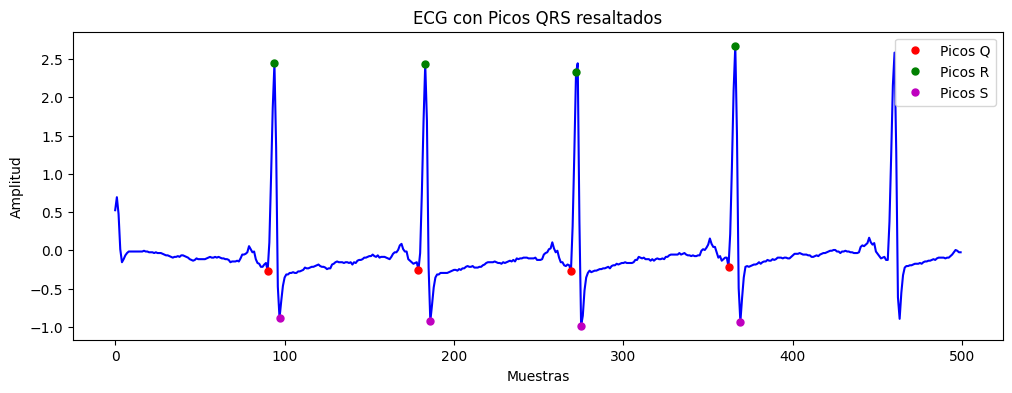

In [42]:
import wfdb
import matplotlib.pyplot as plt
import biosppy.signals.ecg as ecg


from scipy.signal import find_peaks

out = ecg.ecg(signal=ecg_signal, sampling_rate=fs, show=False)
rpeaks = out['rpeaks']
# Detectar los picos Q
qpeaks = []
for rpeak in rpeaks:
    qpeak = ecg_signal[rpeak-40:rpeak]  # Ajusta la ventana de tiempo para buscar los picos Q
    qpeak_index = rpeak - 40 + np.argmin(qpeak)
    qpeaks.append(qpeak_index)

# Obtener los picos de onda S
s_wave_peaks = []
for rpeak in rpeaks:
    # Buscar el punto mínimo dentro de una ventana alrededor del pico R
    s_wave_peak = ecg_signal[rpeak:rpeak+30]  # Ajusta la ventana de tiempo para buscar los picos de onda S
    s_wave_peak_index = rpeak + np.argmin(s_wave_peak)
    s_wave_peaks.append(s_wave_peak_index)

# Graficar el ECG con los picos Q resaltados
plt.figure(figsize=(12, 4))
plt.plot(ecg_signal, color='b')
plt.plot(qpeaks, ecg_signal[qpeaks], 'ro', markersize=5, label='Picos Q', color='r')
plt.plot(rpeaks, ecg_signal[rpeaks], 'ro', markersize=5, label='Picos R', color='g')
plt.plot(s_wave_peaks, ecg_signal[s_wave_peaks], 'ro', markersize=5, label='Picos S',color='m')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.title('ECG con Picos QRS resaltados')
plt.legend()
plt.show()



In [43]:
indice_maximo_qpeaks = np.argmax(qpeaks)
indice_maximo_rpeaks = np.argmax(rpeaks)
indice_maximo_s_wave_peaks = np.argmax(s_wave_peaks)

# Imprimir los índices máximos
print("Índice máximo de qpeaks:", indice_maximo_qpeaks)
print("Índice máximo de rpeaks:", indice_maximo_rpeaks)
print("Índice máximo de s_wave_peaks:", indice_maximo_s_wave_peaks)
combined_peaks = np.concatenate((qpeaks, rpeaks, s_wave_peaks))

# Imprimir la variable con los picos combinados
print("Picos combinados:", combined_peaks)


Índice máximo de qpeaks: 3
Índice máximo de rpeaks: 3
Índice máximo de s_wave_peaks: 3
Picos combinados: [ 90 179 269 362  94 183 272 366  97 186 275 369]


<ipython-input-55-b385850ef413>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PT_peaks, ecg_signal[PT_peaks], 'ro', markersize=5, label='Picos de P y T',color='c')


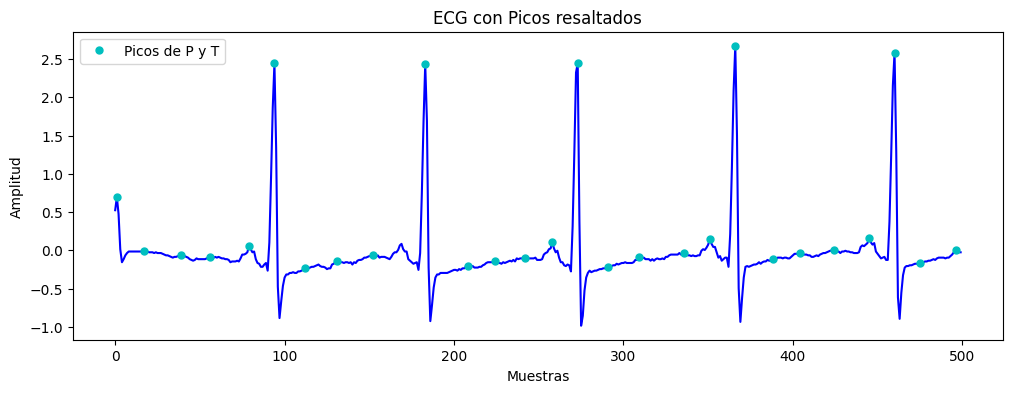

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import wfdb
import matplotlib.pyplot as plt
import biosppy.signals.ecg as ecg
from scipy.signal import find_peaks
# Aplicar el algoritmo de Pan-Tompkins para detectar los complejos QRS
PT_peaks, _ = signal.find_peaks(ecg_signal, distance=15)

# Obtener los picos de la onda P antes de cada complejo QRS
p_wave_peaks = []
for qrs_peak in PT_peaks:
    p_wave_peak = np.argmax(ecg_signal[:qrs_peak])  # Obtener el índice del pico máximo antes del complejo QRS
    p_wave_peaks.append(p_wave_peak)
plt.figure(figsize=(12, 4))
plt.plot(ecg_signal, color='b')

plt.plot(PT_peaks, ecg_signal[PT_peaks], 'ro', markersize=5, label='Picos de P y T',color='c')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.title('ECG con Picos resaltados')
plt.legend()
plt.show()


In [56]:
import pandas as pd

# Verificar la longitud de las listas
if len(qpeaks) == len(rpeaks) == len(s_wave_peaks) == len(PT_peaks):
    # Crear un diccionario con los datos de los picos
    data = {
        'Picos Q': qpeaks,
        'Picos R': rpeaks,
        'Picos S': s_wave_peaks,
        'Picos de P y T': PT_peaks,

    }

    # Crear el DataFrame
    df = pd.DataFrame(data)

    # Imprimir el DataFrame
    print(df)

    # Guardar el DataFrame en un archivo CSV
    df.to_csv('picos_ecg.csv', index=False)
else:
    print("Las listas de picos tienen longitudes diferentes.")


Las listas de picos tienen longitudes diferentes.


In [57]:
combined_peaks = np.concatenate((qpeaks, rpeaks, s_wave_peaks))

In [58]:
import numpy as np

altura_p = []
for peak in PT_peaks:
    inicio_p = np.argmin(ecg_signal[:peak])
    fin_p = np.argmin(ecg_signal[peak:]) + peak
    altura = ecg_signal[peak] - np.min(ecg_signal[inicio_p:fin_p])
    altura_p.append(altura)

# Imprimir las alturas de las ondas P
print("Alturas de las ondas P:", altura_p)

ancho_p = []
for peak in PT_peaks:
    inicio_p = np.argmin(ecg_signal[:peak])
    fin_p = np.argmin(ecg_signal[peak:]) + peak
    ancho = fin_p - inicio_p
    ancho_p.append(ancho)

# Imprimir los anchos de las ondas P
print("Anchos de las ondas P:", ancho_p)

p_end_points = []
for peak in PT_peaks:
    p_wave_width = 10  # Ancho de la onda P (por ejemplo, 10 muestras)
    p_end_point = peak + p_wave_width
    p_end_points.append(p_end_point)

# Imprimir los índices del final de la onda P
print("Índices del final de la onda P:", p_end_points)




Alturas de las ondas P: [1.62, 0.92, 0.8600000000000001, 0.8400000000000001, 0.9800000000000001, 3.37, 0.7000000000000001, 0.78, 0.87, 3.3600000000000003, 0.7200000000000001, 0.78, 0.8300000000000001, 1.03, 3.37, 0.77, 0.9, 0.95, 1.14, 3.6599999999999997, 0.87, 0.95, 0.99, 1.15, 3.57, 0.82, 0.99]
Anchos de las ondas P: [275, 271, 271, 271, 271, 185, 178, 178, 178, 178, 89, 89, 89, 89, 89, 94, 94, 94, 94, 94, 188, 188, 188, 188, 188, 201, 223]
Índices del final de la onda P: [11, 27, 49, 66, 89, 104, 122, 141, 162, 193, 218, 234, 252, 268, 283, 301, 319, 346, 361, 376, 398, 414, 434, 455, 470, 485, 506]


[]


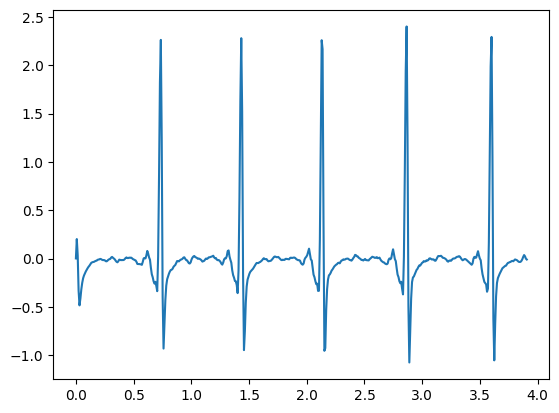

In [59]:
#inicio de parametros de tiempo y amplitud de la senal
Picomax = float(max(ps))
Umbralmax = 0.5*Picomax   #Definicion del umbral para detectar el pico R
Picomin = float(min(ps))  #Deteccion ondas R negativas
Umbralmin = 0.5*Picomin
arregloPico = []
arregloTiempo = []
#Inicio de contadores
contR = 0   #contador de picos R
v1 = 0    #tamano de las ventanas
ventana = int(0.353 * fs)
while ventana < len(ps):
  senal = ps[v1:ventana]
  estePicomax = float(max(senal))
  esteTiempopico = v1+np.argmax(senal)
  time = ecg_time[esteTiempopico] #Relaciona la posicion del punto del pico maximo con el tiempo
  
  if estePicomax > Umbralmax:
    arregloPico.append(estePicomax)
    arregloTiempo.append(time)

  if estePicomax < Umbralmin:
    arregloPico.append(estePicomax)
    arregloTiempo.append(time)

  v1 += ventana
  ventana += ventana

plt.plot(arregloTiempo, arregloPico, 'or')


print(arregloTiempo)
#print(Umbral)
plt.plot((ecg_time),ps)